# Examples of Gaussian Process Regression in High Energy Physics

In [1]:
import ROOT
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF, Matern
import numpy as np
from plotting import plot
import random

Welcome to JupyROOT 6.28/04


In [2]:
plot_dir = '../../../CERN/Presentations/Images/' # Set this to None to not save plot images

def save(c, file_name):
    if plot_dir:
        c.Print(plot_dir + file_name)

In [3]:
def canvas():
    c = ROOT.TCanvas('c', '', 1000, 800)
    c.SetFillColor(plot.colors.transparent_white)
    return c

## Dummy Data

In [22]:
### Create example data ###
n = 10
m_min = 500
m_max = 1000

f_true = ROOT.TF1('f_true', f'[0] * e^(-(x - {m_min}) / [1])', m_min, m_max)
f_true.SetParameters(200, 200)

h_data = ROOT.TH1F('h', '', n, m_min, m_max)
x_train = []
y_train = []
signal_region_bins = [n//2 - 1, n//2] # exclusive top
signal_region_bin_centers = [h_data.GetBinCenter(i) for i in signal_region_bins]

vals = [
    170.51515197753906,
    136.9337921142578,
    103.4233627319336,
    0.0,
    0.0,
    49.4085807800293,
    35.14250946044922,
    37.4783821105957,
    27.984872817993164,
    13.629623413085938,
]

for i in range(1, n+1):
    if i in signal_region_bins: continue
    x = h_data.GetBinCenter(i)
    # v = f_true(x)
    # v += np.random.normal(scale=1.2 * v**0.5) # add some noise
    # print(v)
    v = vals[i - 1]
    h_data.SetBinContent(i, v)
    x_train.append(x)
    y_train.append(v)

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_datapoints.pdf has been created


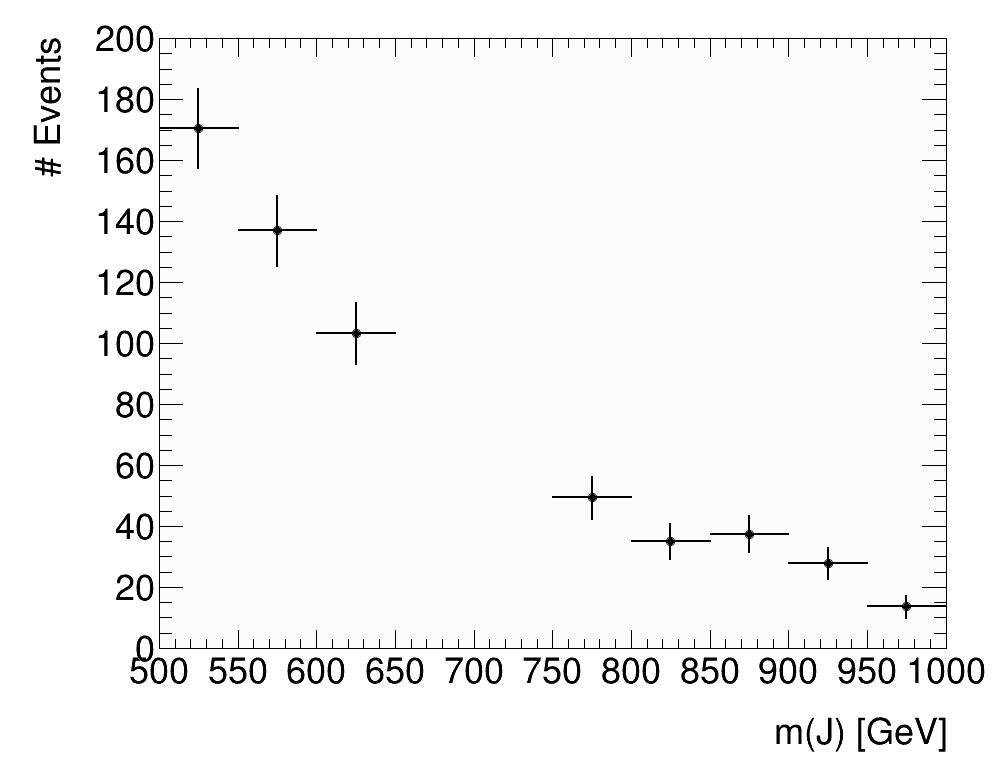

In [5]:
### Plot data ###
c = canvas()
plot._plot(c, [h_data],
    opts=['E'],
    xtitle='m(J) [GeV]',
    ytitle='# Events',
    yrange=[0,200],
)
c.Draw()
save(c, 'gpr_hep_datapoints.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_data.pdf has been created


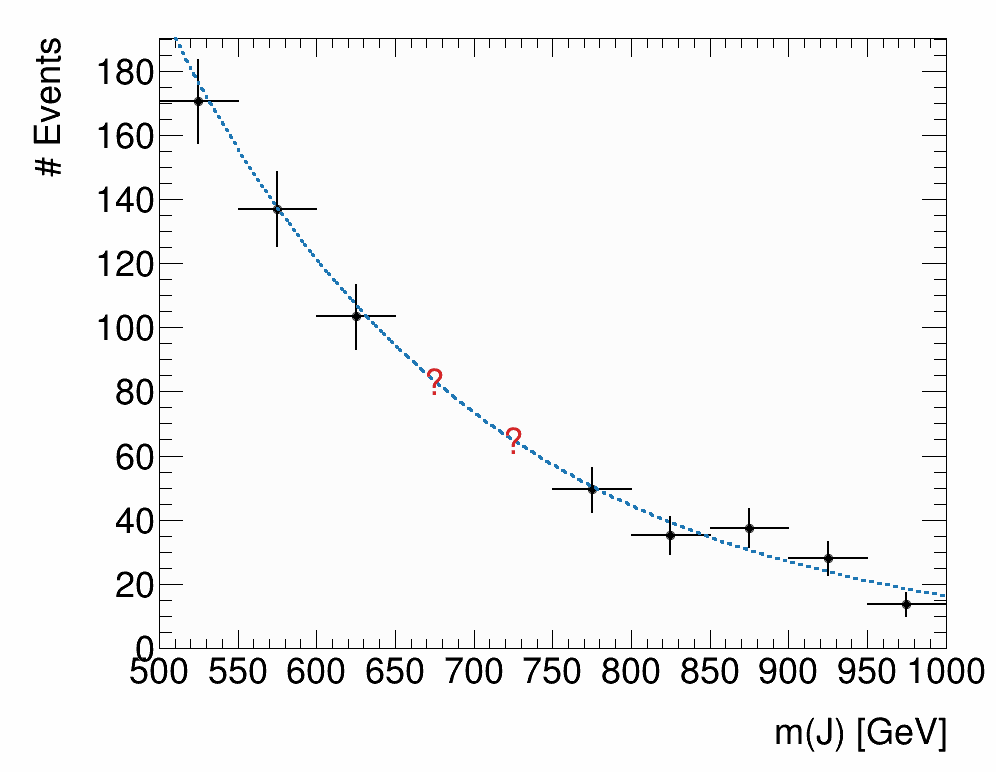

In [6]:
### Plot data with curves ###
c = canvas()
f_true.SetLineColor(plot.colors.blue)
f_true.SetLineStyle(ROOT.kDashed)

plot._plot(c, [h_data, f_true],
    opts=['E', ''],
    xtitle='m(J) [GeV]',
    ytitle='# Events',
)

# Question marks
texts = []
for x in signal_region_bin_centers:
    t = ROOT.TLatex(x, f_true(x), '?')
    t.SetTextColor(plot.colors.red)
    t.SetTextAlign(ROOT.kHAlignCenter + ROOT.kVAlignCenter)
    t.Draw()
    texts.append(t)

# Draw
c.Draw()
save(c, 'gpr_hep_data.pdf')

## Dummy Functions

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_badfuncs.pdf has been created


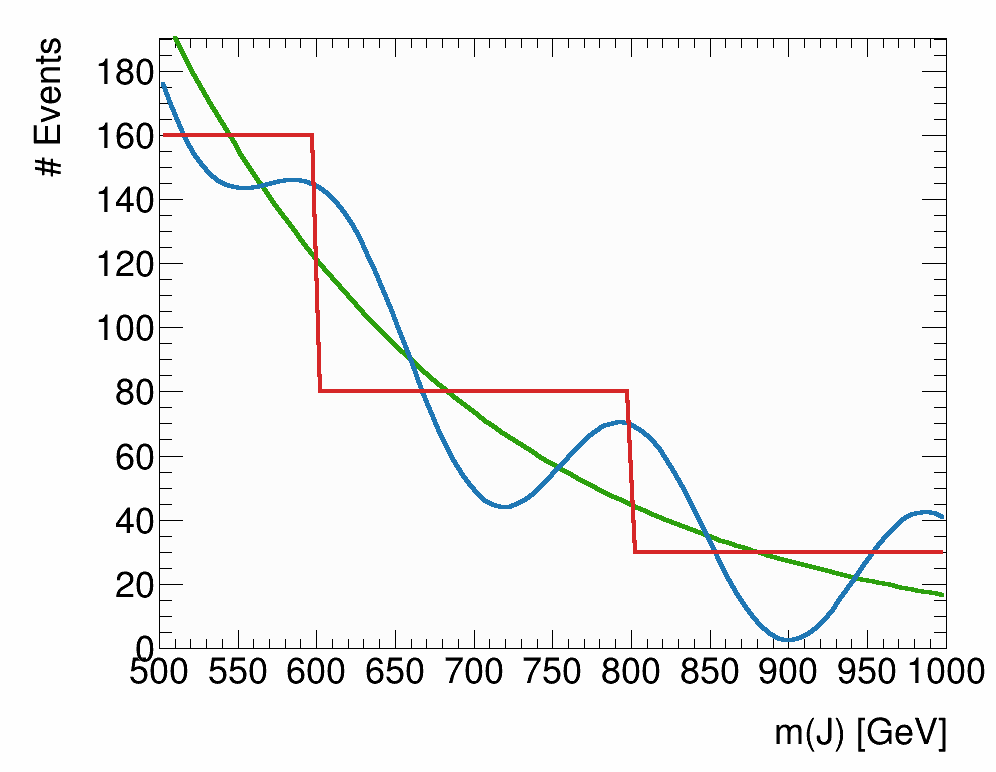

In [13]:
### Bad Functions ###
f_wiggly = ROOT.TF1('f_wiggly', f'[0] * e^(-(x - {m_min}) / [1]) + 25 * sin(x / 30)', m_min, m_max)
f_wiggly.SetParameters(200, 200)

def _step_func(xs, pars):
    x = xs[0]
    if x < 600: return 160
    if x < 800: return 80
    return 30
f_step = ROOT.TF1('f_step', _step_func, m_min, m_max)

c = canvas()
plot._plot(c, [h_data, f_true, f_wiggly, f_step], # use h_data as the axes but don't actually plot it
    opts=['E', '', '', ''],
    linecolor=[ROOT.kBlack, plot.colors.green, plot.colors.blue, plot.colors.red],
    linestyle=ROOT.kSolid,
    linewidth=[0] + [4] * 3,
    markersize=0,
    xtitle='m(J) [GeV]',
    ytitle='# Events',
)

# Question marks
# texts = []
# for x in signal_region_bin_centers:
#     t = ROOT.TLatex(x, f_true(x), '?')
#     t.SetTextColor(plot.colors.red)
#     t.SetTextAlign(ROOT.kHAlignCenter + ROOT.kVAlignCenter)
#     t.Draw()
#     texts.append(t)

# Draw
c.Draw()
save(c, 'gpr_hep_badfuncs.pdf')


In [ ]:
### Functions as Points ###
funcs = [f_true, f_wiggly]
names = ['f1', 'f2']
colors = [plot.colors.green, plot.colors.blue]
colors_latex = ['tgreen', 'tblue']

for f,name,color,ctex in zip(funcs, names, colors, colors_latex):
    n_step = 50
    h = ROOT.TH1F(f'h_{name}', '', n_step, m_min, m_max)
    for i in range(n_step):
        h.SetBinContent(i+1, f(h.GetBinCenter(i+1)))
        if i < 5:
            print(f'{h.GetBinCenter(i+1)} & \\{ctex}' + '{' + str(round(h.GetBinContent(i+1))) + r'} \\')
    print('')

    c = canvas()
    plot._plot(c, [h, f],
        opts=['P', ''],
        linecolor=color,
        markercolor=color,
        linewidth=1,
        xtitle='m(J) [GeV]',
        ytitle='# Events',
    )

    c.Draw()
    save(c, f'gpr_hep_{name}-points.pdf')

In [ ]:
### Random Functions ###
_rands = 25 + 50 * np.random.randint(0, 4, 100)
def _random_func(xs, pars):
    x = xs[0]
    i = int((x - 500) / 10) % 100
    return _rands[i]

fs = [
    f_wiggly,
    ROOT.TF1('f2', f'50 + 100 * (x - 500) / 500', m_min, m_max),
    ROOT.TF1('f3', '100 + 25 * sin(x / 20)', m_min, m_max),
    ROOT.TF1('f4', _random_func, m_min, m_max),
]

### Empty axes ###
c = canvas()
plot._plot(c, [h_data], 
    opts=['E'],
    linecolor=[ROOT.kBlack],
    linestyle=ROOT.kSolid,
    linewidth=[0],
    markersize=0,
    xtitle='m(J) [GeV]',
    ytitle='# Events',
    yrange=(0, 200),
)
save(c, f'gpr_hep_f_empty.pdf')

### Single function plots ###
for i,f in enumerate(fs):
    c = canvas()
    plot._plot(c, [h_data, f], # use h_data as the axes but don't actually plot it
        opts=['E', ''],
        linecolor=[ROOT.kBlack, plot.colors.tableu(i)],
        linestyle=ROOT.kSolid,
        linewidth=[0, 4],
        markersize=0,
        xtitle='m(J) [GeV]',
        ytitle='# Events',
        yrange=(0, 200),
    )

    c.Draw()
    save(c, f'gpr_hep_f{i+1}.pdf')

In [ ]:
### Random Functions Mean ###
start_i = len(fs)
f_mean = ROOT.TF1('mean', '180 - 160 * (x - 500) / 500', m_min, m_max)

### Mean ###
c = canvas()
plot._plot(c, [h_data, f_mean], # use h_data as the axes but don't actually plot it
    opts=['E', ''],
    linecolor=ROOT.kBlack,
    linestyle=ROOT.kSolid,
    linewidth=[0, 4],
    markersize=0,
    xtitle='m(J) [GeV]',
    ytitle='# Events',
    yrange=(0, 200),
)
c.Draw()
save(c, f'gpr_hep_f{start_i+1}.pdf')
start_i += 1

### Dashed Mean ###
c = canvas()
plot._plot(c, [h_data, f_mean], # use h_data as the axes but don't actually plot it
    opts=['E', ''],
    linecolor=ROOT.kBlack,
    linestyle=ROOT.kDashed,
    linewidth=[0, 2],
    markersize=0,
    xtitle='m(J) [GeV]',
    ytitle='# Events',
    yrange=(0, 200),
)
c.Draw()
save(c, f'gpr_hep_f_empty-mean.pdf')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_f8.pdf has been created


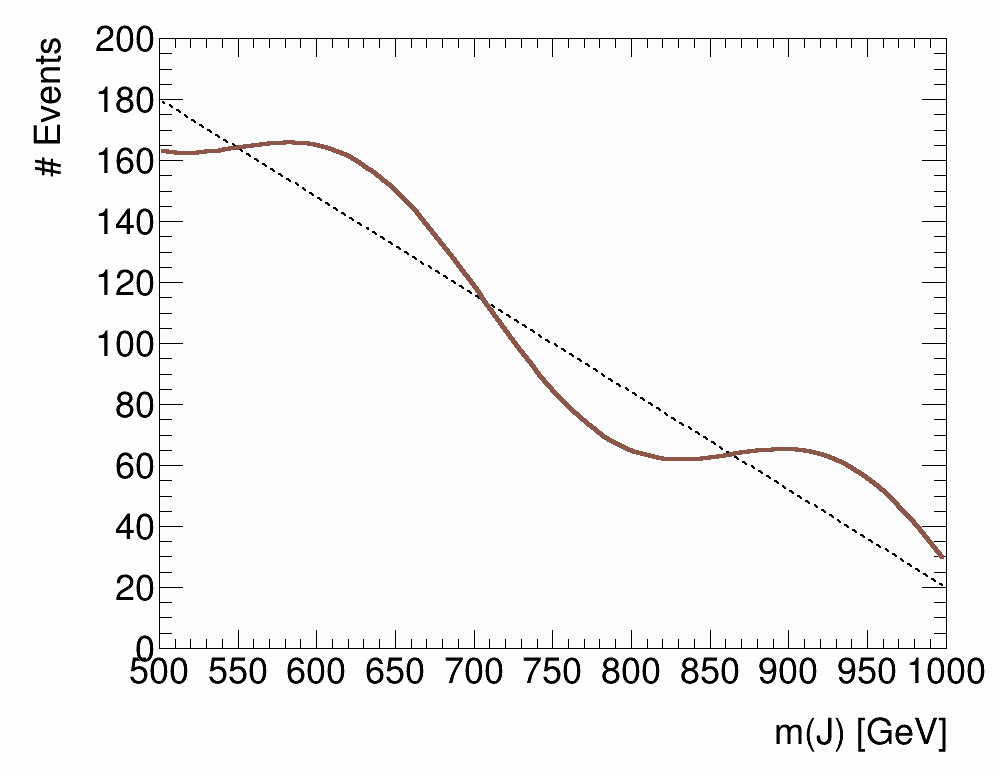

In [16]:
### Random Functions Mean Plus Other ###
fs = [
    ROOT.TF1('f6', 'mean(x) - 20 + 80 * (500 / x) * cos(x / 50)', m_min, m_max),
    ROOT.TF1('f7', 'mean(x) + 20 * cos(x / 5)', m_min, m_max),
    ROOT.TF1('f8', 'mean(x) + 20 * cos(x / 50)', m_min, m_max),
]
colors = [
    plot.colors.orange,
    plot.colors.green,
    plot.colors.brown,
]

for i,f in enumerate(fs):
    if i != len(fs) - 1: continue
    c = canvas()
    plot._plot(c, [h_data, f_mean, f], # use h_data as the axes but don't actually plot it
        opts=['E', '', ''],
        linecolor=[ROOT.kBlack, ROOT.kBlack, colors[i]],
        linestyle=[0, ROOT.kDashed, ROOT.kSolid],
        linewidth=[0, 2, 4],
        markersize=0,
        xtitle='m(J) [GeV]',
        ytitle='# Events',
        yrange=(0, 200),
    )

    c.Draw()
    save(c, f'gpr_hep_f{start_i+i+1}.pdf')

## 3D Example

Warning in <TROOT::Append>: Replacing existing TH1: h0 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_3d_n1.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_3d_n2.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_3d_n3.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_3d_n4.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_3d_n5.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas

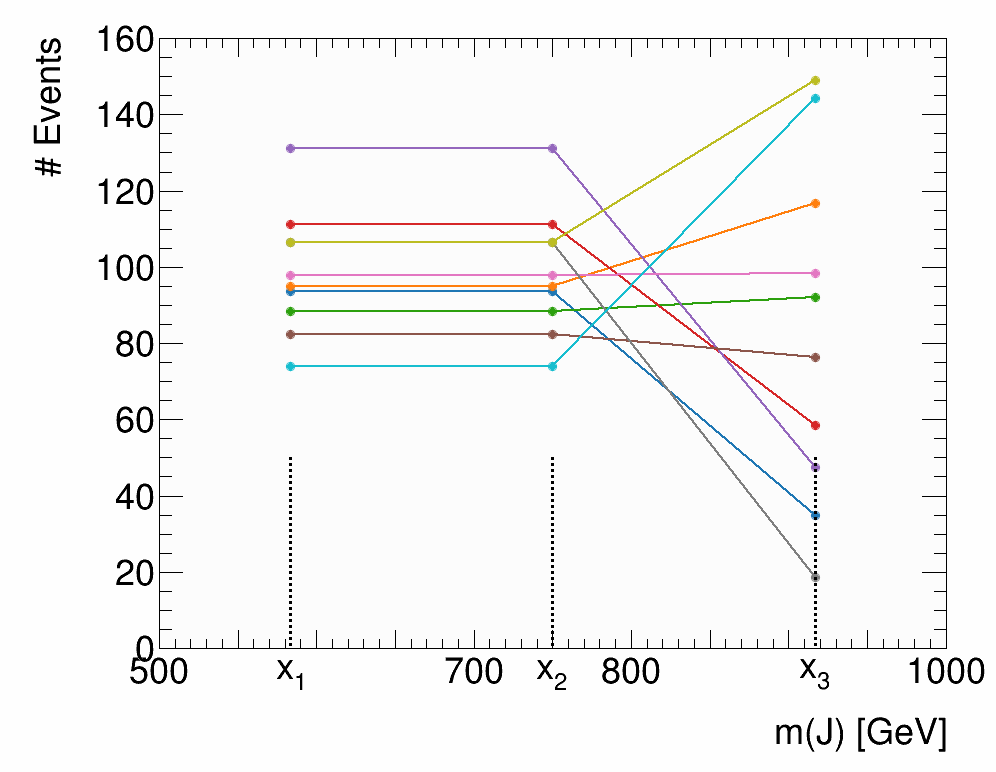

In [198]:
n = 3
mean = 100 * np.ones(n)
cov = [[20**2, 20**2, 0], [20**2, 20**2, 0], [0, 0, 40**2]]

hists = []
for sample in range(10):
    ### Draw random functions ###
    h = ROOT.TH1F(f'h{sample}', '', n, m_min, m_max)
    f = np.random.multivariate_normal(mean, cov)
    for i,fi in enumerate(f):
        h.SetBinContent(i+1, fi)
    hists.append(h)

    ### Plot functions ###
    c = canvas()
    plot._plot(c, hists,
        opts='PL',
        xtitle='m(J) [GeV]',
        ytitle='# Events',
        linecolor=plot.colors.tableu,
        markercolor=plot.colors.tableu,
        yrange=(0, 160),
    )

    ### Remove tick marks from overlapping ###
    if sample == 0:
        ax = h.GetXaxis()
        for i in [2, 3, 4, 6, 8, 9, 10]:
            ax.ChangeLabel(i, -1, 0)

    ### x_i labels ###
    cache = []
    for i in range(n):
        x = h.GetBinCenter(i+1)

        l = ROOT.TLine(x, 0, x, 50)
        l.SetLineStyle(ROOT.kDashed)
        l.SetLineWidth(3)
        l.Draw()

        t = ROOT.TLatex(x, -11, f'x_{{{i+1}}}')
        t.SetTextAlign(ROOT.kHAlignCenter)
        t.Draw()

        cache.append(l)
        cache.append(t)

    save(c, f'gpr_hep_3d_n{sample+1}.pdf')

c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_mean (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mean (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_3d_mean.pdf has been created


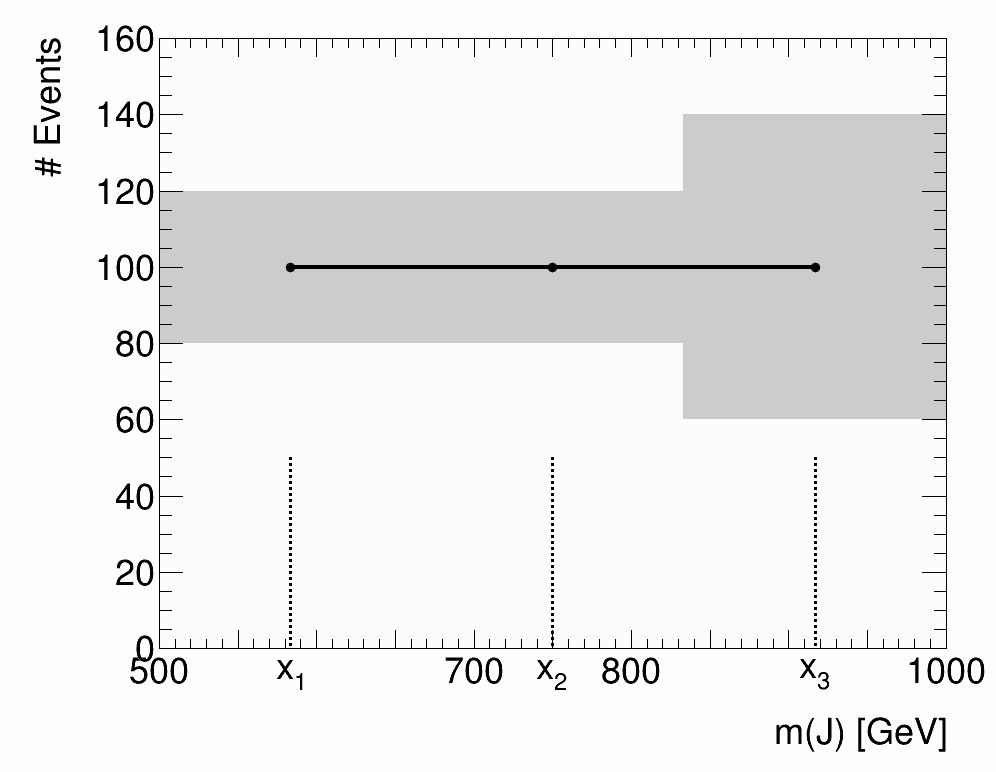

In [208]:
### Mean and variance ###
h = ROOT.TH1F(f'h_mean', '', n, m_min, m_max)
for i in range(n):
    h.SetBinContent(i+1, mean[i])
    h.SetBinError(i+1, cov[i][i]**0.5)
h.SetLineWidth(4)

h_band = h.Clone()
h_band.SetFillColor(ROOT.kGray)

### Plot functions ###
c = canvas()
plot._plot(c, [h_band, h],
    opts=['E2', 'HIST PL'],
    xtitle='m(J) [GeV]',
    ytitle='# Events',
    yrange=(0, 160),
)

### Remove tick marks from overlapping ###
ax = h_band.GetXaxis()
for i in [2, 3, 4, 6, 8, 9, 10]:
    ax.ChangeLabel(i, -1, 0)

### x_i labels ###
cache = []
for i in range(n):
    x = h.GetBinCenter(i+1)

    l = ROOT.TLine(x, 0, x, 50)
    l.SetLineStyle(ROOT.kDashed)
    l.SetLineWidth(3)
    l.Draw()

    t = ROOT.TLatex(x, -11, f'x_{{{i+1}}}')
    t.SetTextAlign(ROOT.kHAlignCenter)
    t.Draw()

    cache.append(l)
    cache.append(t)

save(c, f'gpr_hep_3d_mean.pdf')
c.Draw()

## Gaussian Process Setup

In [9]:
def se_kernel(a, b, l=1, g=1):
    '''
    Finds the squared exponential correlation matrix between two datasets [a] and [b].

    @param a
        A (d, n) matrix corresponding to n input vectors of dimension d.
    @param b
        A (d, m) matrix corresponding to m input vectors of dimension d.
    @return
        The (n, m) correlation matrix between [a] and [b].
    '''
    (d, n) = a.shape
    a2 = np.sum(a**2, 0) # 1 by n, magnitude of each column
    b2 = np.sum(b**2, 0) # 1 by m
    r2 = a2.reshape(n,1) + b2 # n by m, the sum broadcasts both vectors
    r2 = r2 - 2 * np.dot(a.T, b)
    return g**2 * np.exp(-.5 / l**2 * r2)

In [10]:
def matern32_kernel(a, b, l=1, g=1):
    '''
    @param a
        A (d, n) matrix corresponding to n input vectors of dimension d.
    @param b
        A (d, m) matrix corresponding to m input vectors of dimension d.
    @return
        The (n, m) correlation matrix between [a] and [b].
    '''
    (d, n) = a.shape
    a2 = np.sum(a**2, 0) # 1 by n, magnitude of each column
    b2 = np.sum(b**2, 0) # 1 by m
    r2 = a2.reshape(n,1) + b2 # n by m, the sum broadcasts both vectors
    r2 = r2 - 2 * np.dot(a.T, b)
    r = np.sqrt(r2)
    return g**2 * (1 + 3**0.5 * r / l) * np.exp(-3**0.5 * r / l)

In [11]:
def rational_quadratic_kernel(a, b, l=1, alpha=2, g=1):
    '''
    @param a
        A (d, n) matrix corresponding to n input vectors of dimension d.
    @param b
        A (d, m) matrix corresponding to m input vectors of dimension d.
    @return
        The (n, m) correlation matrix between [a] and [b].
    '''
    (d, n) = a.shape
    a2 = np.sum(a**2, 0) # 1 by n, magnitude of each column
    b2 = np.sum(b**2, 0) # 1 by m
    r2 = a2.reshape(n,1) + b2 # n by m, the sum broadcasts both vectors
    r2 = r2 - 2 * np.dot(a.T, b)
    return g**2 * np.power(1 + r2 / (2 * alpha * l**2), -alpha)

In [12]:
def std_dev(cov):
    '''
    Extracts the standard deviations given a covariance matrix.

    @param cov
        A (n, n) covariance matrix
    @return
        The (n) standard deviations
    '''
    return np.sqrt(np.diag(cov))

In [13]:
def get_posterior(X_train, y_train, X_test, kernel, mean=None, y_noise=1e-10):
    '''
    Calculates the posterior mean and covariance, along with the prior covariance,
    given a set of training and testing points.

    @param X_train
        A (d, n) matrix corresponding to n training points of dimension d.
    @param y_train
        A (n) vector corresponding to the target values.
    @param X_test
        A (d, m) matrix corresponding to m testing points of dimension d.
    @param kernel
        A kernel function (A, B) -> C to define the process. It should accept 
        input matrices of dimension (d, n) and (d, m) respectively, corresponding 
        to input vectors of dimension d, and output the (n, m) correlation matrix 
        between A and B.
    @param y_noise
        Noise to apply to the training targets. Don't set this to 0, as some noise
        helps prevent numerical instability. 
    @return
        A tuple (prior covariance, posterior mean, posterior covariance).
        The covariances are (m, m) matrices and the mean is a (m) vector.
    '''
    n = X_train.shape[1]
    m = X_test.shape[1]
    if mean is not None:
        y_train = y_train - mean(X_train)
    if not hasattr(y_noise, "__len__"):
        y_noise = y_noise * np.ones(n)

    K_XX = kernel(X_train, X_train) # (n, n)
    K_XY = kernel(X_train, X_test)  # (n, m)
    K_YY = kernel(X_test, X_test)   # (m, m)

    L = np.linalg.cholesky(K_XX + np.diag(y_noise)) # (n, n)
    v = np.linalg.solve(L, K_XY) # (n, m)
    temp = np.linalg.solve(L, y_train) # (n)

    mean_post = v.T.dot(temp) # (m)
    if mean is not None: mean_post += mean(X_test)
    cov_prior = K_YY # (m, m)
    cov_post = K_YY - np.dot(v.T, v) # (m, m)

    alpha = np.linalg.solve(L.T, temp)
    log_margl = -0.5 * y_train.dot(alpha)
    log_margl -= np.sum(np.log(np.diag(L)))
    log_margl -= n/2 * np.log(2 * np.pi)

    return cov_prior, mean_post, cov_post, log_margl

In [14]:
def draw_gp(mean, cov, file_name, n_samples=4, h_data=None, color=ROOT.kBlack, **kwargs):
    c = canvas()

    ### Mean and band ###
    h_mean = ROOT.TH1F('h_mean', '', n_test, m_min, m_max)
    for i in range(n_test):
        h_mean.SetBinContent(i+1, mean[i])
        h_mean.SetBinError(i+1, 2 * cov[i][i]**0.5)

    h_mean.SetLineStyle(ROOT.kSolid)
    h_mean.SetLineWidth(4)
    h_mean.SetLineColor(color)
    h_mean.SetMarkerSize(0)

    h_band = h_mean.Clone()
    h_band.SetFillColorAlpha(color, 0.5)

    ### Samples ###
    h_samps = []
    for i in range(n_samples):
        vals = np.random.multivariate_normal(mean, cov)
        h_samp = h_mean.Clone()
        for x,val in enumerate(vals):
            h_samp.SetBinContent(x+1, val)
            h_samp.SetBinError(x+1, 0)
        h_samp.SetLineColor(plot.colors.tableu(i))
        h_samp.SetLineWidth(2)
        h_samp.SetLineStyle(ROOT.kSolid)
        h_samps.append(h_samp)

    ### Data points ###
    hists = [h_band, h_mean] + h_samps
    if h_data is not None:
        h_data.SetMarkerSize(1)
        h_data.SetLineColor(ROOT.kBlack)
        h_data.SetLineWidth(2)
        hists.append(h_data)
        

    ### Plot ###
    cache = plot._plot(c, hists,
        opts=['E2', 'HIST L'] + ['C']*n_samples + ['PE'],
        xtitle='m(J) [GeV]',
        ytitle='# Events',
        **kwargs,
    )

    ### Question marks ###
    texts = []
    # if draw_data:
    #     for x in signal_region_bin_centers:
    #         t = ROOT.TLatex(x, f_true(x), '?')
    #         t.SetTextColor(plot.colors.red)
    #         t.SetTextAlign(ROOT.kHAlignCenter + ROOT.kVAlignCenter)
    #         t.Draw()
    #         texts.append(t)

    ### Draw ###
    c.RedrawAxis()
    c.Draw()
    save(c, file_name)
    return [c, h_mean, h_band, h_samps, cache, texts]
    

## Gaussian Process Testbench

In [113]:
X_train = np.reshape(x_train, (1, -1))
y_train = np.array(y_train)
e_train = np.sqrt(y_train)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_prior_matern_nu1.5_l70_g20.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h_mean (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mean (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mean (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mean (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mean (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mean (Potential memory leak).
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_post_matern_nu1.5_l70_g20.pdf has been created


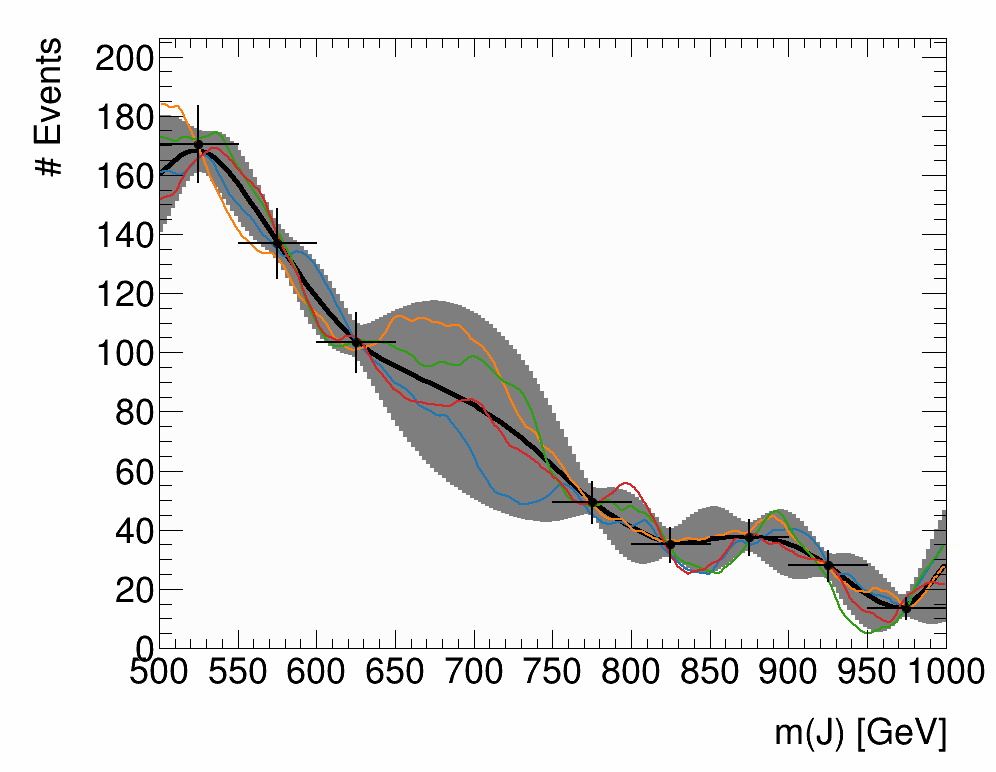

In [114]:
n_test = 200
length_scale = 70
gamma_factor = 20
X_test = np.linspace(m_min, m_max, n_test).reshape(1, -1) # (1, m)
mean_prior = np.ones(n_test) * 100 # (m)
def mean(x): return 100
# def kernel(x, y): return se_kernel(x, y, l=length_scale, g=gamma_factor)
def kernel(x, y): return matern32_kernel(x, y, l=length_scale, g=gamma_factor)
# def kernel(x, y): return rational_quadratic_kernel(x, y, l=length_scale, g=gamma_factor)
kernel_name = f'matern_nu1.5_l{length_scale}_g{gamma_factor}'

# Solve
cov_prior, mean_post, cov_post, _ = get_posterior(X_train, y_train, X_test, kernel, mean, e_train)

# Plot prior
_ = draw_gp(mean_prior, cov_prior, f'gpr_hep_prior_{kernel_name}.pdf')

# Plot posterior
_ = draw_gp(mean_post, cov_post, f'gpr_hep_post_{kernel_name}.pdf', draw_data=True)


WARNING! _get_minmax_all() min_pos is None, setting to 0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_margl.pdf has been created


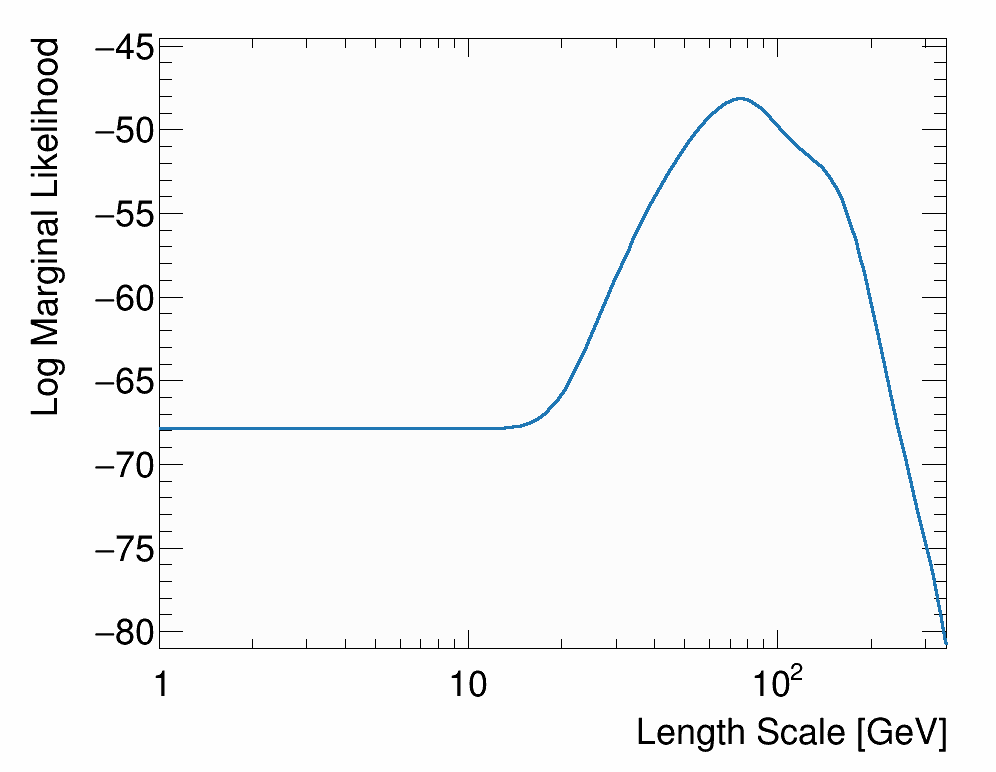

In [115]:
### Marginal Likelihood Scan ###
X_test = np.linspace(m_min, m_max, 200).reshape(1, -1) # (1, m)
def mean(x): return 100

length_scale_range = [1, 1000]
test_points = 50

log_range = np.log10(length_scale_range)
length_scales = np.logspace(*log_range, num=test_points)

g_lml = ROOT.TGraph(test_points)
g_chi2 = ROOT.TGraph(test_points)
for i,length_scale in enumerate(length_scales):
    gamma_factor = 20
    def kernel(x, y): return se_kernel(x, y, l=length_scale, g=gamma_factor)
    cov_prior, mean_post, cov_post, log_margl = get_posterior(X_train, y_train, X_test, kernel, mean, e_train)
    g_lml.SetPoint(i, length_scale, log_margl)

    _, mean_post, cov_post, _ = get_posterior(X_train, y_train, X_train, kernel, mean, e_train)
    chi2_diff = np.square(y_train - mean_post) / (np.diag(cov_post) + y_train)
    g_chi2.SetPoint(i, length_scale, np.mean(chi2_diff))

c = canvas()
plot._plot(c, [g_lml], 
    ytitle='Log Marginal Likelihood',
    xtitle='Length Scale [GeV]',
    opts='C',
    logx=True,
    xrange=[1, 350],
    linewidth=3,
    linecolor=plot.colors.blue,
)
c.Draw()
save(c, 'gpr_hep_margl.pdf')

WARNING! _get_minmax_all() min_pos is None, setting to 0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_chi2.pdf has been created


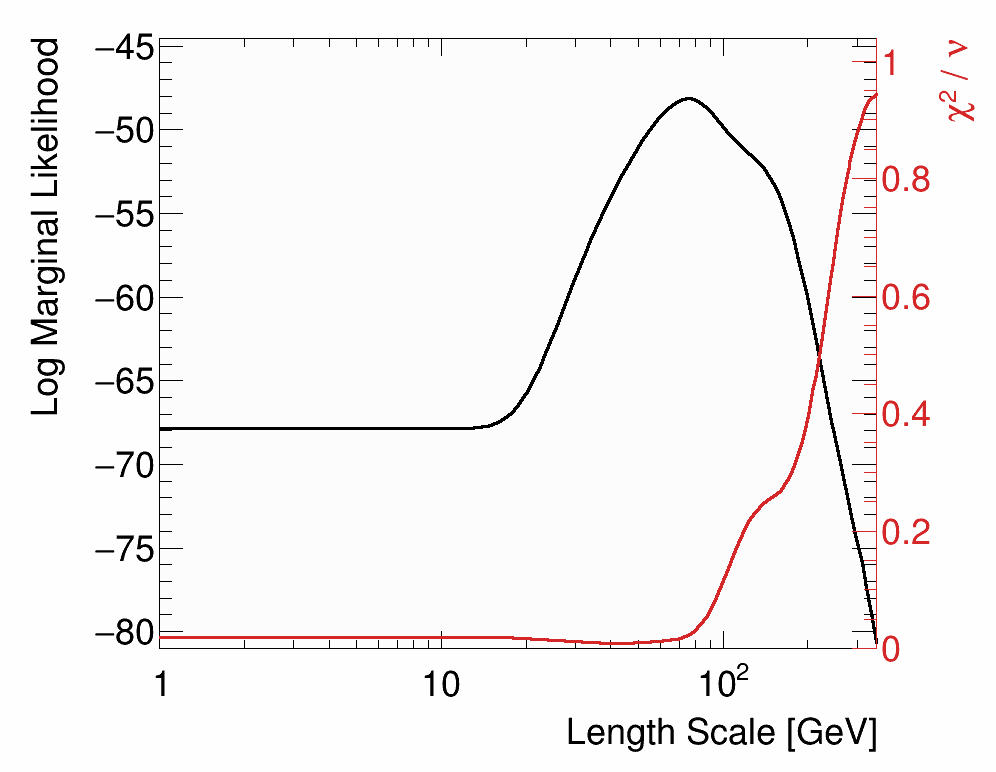

In [116]:
### Chi2 Plot ###
c = canvas()
_ = plot.plot_two_scale([g_lml], [g_chi2], 
    canvas=c,
    title=None,
    ytitle='Log Marginal Likelihood',
    ytitle2='#chi^{2} / #nu',
    xtitle='Length Scale [GeV]',
    opts='C',
    opts2='C',
    logx=True,
    xrange=[1, 350],
    linewidth=3,
    linewidth2=3,
    linecolor=ROOT.kBlack,
    linecolor2=plot.colors.red,
)
c.Draw()
save(c, 'gpr_hep_chi2.pdf')

In [117]:
### Dummy Marginal Likelihoods ###

f1 = ROOT.TF1('f1', 'gaus(0)', -100, 100)
f1.SetParameters(1/10, -8, 10)

f2 = ROOT.TF1('f1', 'gaus(0)', -100, 100)
f2.SetParameters(1/6, 15, 6)

f3 = ROOT.TF1('f1', 'gaus(0)', -100, 100)
f3.SetParameters(1/30, 0, 30)

c = canvas()
_ = plot._plot(c, [f1, f2, f3],
    title=None,
    ytitle='Marginal Likelihood p(#font[22]{y})',
    xtitle='#font[22]{y}-space',
    yrange=[0, 0.2],
    legend=[
        'Normal Model',
        'Simple Model',
        'Complex Model',
    ],
    legend_opts='L',
    linecolor=plot.colors.tableu,
)

### Remove tick labels ###
f1.GetXaxis().SetLabelOffset(999)
f1.GetXaxis().SetLabelSize(0)
f1.GetYaxis().SetLabelOffset(999)
f1.GetYaxis().SetLabelSize(0)


### y observed line ###
l = ROOT.TLine(0, 0, 0, 0.2)
l.SetLineStyle(ROOT.kDashed)
l.SetLineWidth(3)
l.Draw()

t = ROOT.TLatex(0, -0.02, '#font[22]{y}_{observed}')
t.SetTextAlign(ROOT.kHAlignCenter)
t.Draw()

cache.append(l)
cache.append(t)

c.Draw()
save(c, 'gpr_hep_margl_intuit.pdf')

NameError: name 'cache' is not defined

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


## Gaussian Process Draws Example

In [15]:
X_train = np.reshape(x_train, (1, -1))
y_train = np.array(y_train)
e_train = np.sqrt(y_train)

n_test = 200
X_test = np.linspace(m_min, m_max, n_test).reshape(1, -1) # (1, m)

def mean(x): return (180 - 160 * (x - 500) / 500).reshape(-1)

length_scale = 100
gamma_factor = 20
def kernel(x, y): return se_kernel(x, y, l=length_scale, g=gamma_factor)
kernel_name = f'rbf_l{length_scale}_g{gamma_factor}'

# Solve
cov_prior, mean_post, cov_post, _ = get_posterior(X_train, y_train, X_test, kernel, mean, e_train)

In [ ]:
### Draw samples ###
h_mean = ROOT.TH1F('h_mean', '', n_test, m_min, m_max)
hists = []

for i in range(3):
    vals = np.random.multivariate_normal(mean_post, cov_post)
    h_samp = h_mean.Clone()
    for x,val in enumerate(vals):
        h_samp.SetBinContent(x+1, val)
    hists.append(h_samp)

    ### Plot data with curves ###
    c = canvas()
    _ = plot._plot(c, [h_data] + hists + [h_data],
        opts=['E'] + ['L'] * len(hists) + ['E'],
        linecolor=[ROOT.kBlack] + plot.colors.tableu_l[1:len(hists)+1] + [ROOT.kBlack],
        linewidth=[2] + [3]*len(hists) + [2],
        xtitle='m(J) [GeV]',
        ytitle='# Events',
        yrange=[0,200],
        title=None,
        legend=None,
    )
    c.Draw()
    save(c, f'gpr_hep_post_{kernel_name}_samp{i}.pdf')

In [ ]:
for x,val in enumerate(mean_post):
    h_mean.SetBinContent(x+1, val)

c = canvas()
plot._plot(c, [h_data] + hists + [h_mean, h_data],
    opts=['E'] + ['L'] * len(hists) + ['L', 'E'],
    linecolor=[ROOT.kBlack] + plot.colors.tableu_l[1:len(hists)+1] + [plot.colors.purple, ROOT.kBlack],
    linewidth=[2] + [1]*len(hists) + [5, 2],
    xtitle='m(J) [GeV]',
    ytitle='# Events',
    yrange=[0,200],
)

c.Draw()
save(c, f'gpr_hep_post_{kernel_name}_mean.pdf')

In [ ]:
_ = draw_gp(mean_post, cov_post, f'gpr_hep_post_{kernel_name}_band.pdf', n_samples=0, draw_data=True, color=plot.colors.purple, yrange=[0,200])

## Covariance Pulls

In [ ]:
def pull_plot(file_name, add_ons=None):
    c = canvas()
    _ = plot._plot(c, [h_data],
        opts=['E'],
        linecolor=ROOT.kBlack,
        linewidth=0,
        markersize=0,
        xtitle='m(J) [GeV]',
        ytitle='# Events',
        yrange=[0,200],
        textpos='topright',
        titlesize=0.08,
        title=None,
        subtitle='W+jets',
        legend=None,
    )
    if add_ons: add_ons()

    c.Draw()
    save(c, file_name)
    return [c, _]

_ = pull_plot('gpr_hep_shift_empty.pdf')

In [ ]:
f_orig = ROOT.TF1('f_orig', '0.8 * f_true(x) * (1 + 0.3 * cos(x / 100))', m_min, m_max)
f_orig.SetLineColor(plot.colors.blue)
f_orig.SetLineWidth(3)

def add_ons():
    f_orig.Draw('SAME L')

_ = pull_plot('gpr_hep_shift_orig.pdf', add_ons)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_shift_points.pdf has been created


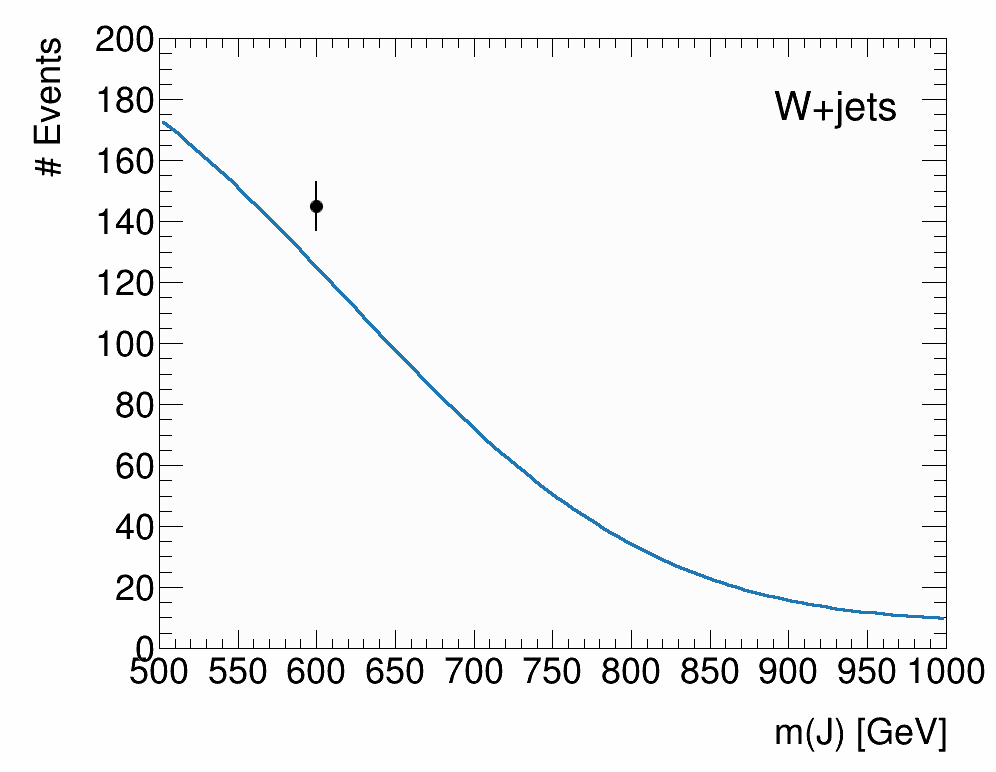

In [156]:
g = ROOT.TGraphErrors(1)
g.SetPoint(0, 600, f_orig(600) + 20)
g.SetPointError(0, 0, 8)
g.SetMarkerSize(1.5)
g.SetLineWidth(2)

def add_ons():
    f_orig.Draw('SAME L')
    g.Draw('SAME P')
    
_ = pull_plot('gpr_hep_shift_points.pdf', add_ons)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_shift_f0.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_shift_f1.pdf has been created


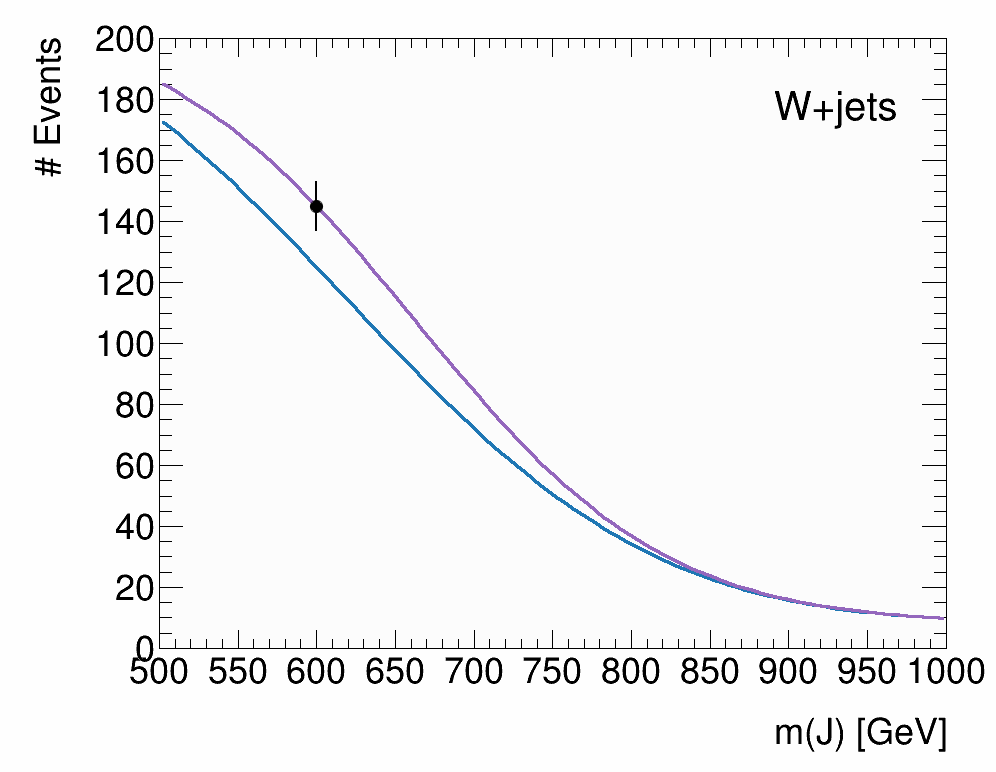

In [158]:
funcs = [
    ROOT.TF1('f1', 'f_orig(x) + 20*exp(-0.5*((x-600)/10)**2)', m_min, m_max),
    ROOT.TF1('f2', 'f_orig(x) + 20*exp(-0.5*((x-600)/100)**2)', m_min, m_max),
]

for i,f in enumerate(funcs):
    f.SetLineColor(plot.colors.purple)
    # f.SetLineStyle(ROOT.kDashed)
    f.SetLineWidth(3)

    def add_ons():
        f_orig.Draw('SAME L')
        f.Draw('SAME L')
        g.Draw('SAME P')
    
    _ = pull_plot(f'gpr_hep_shift_f{i}.pdf', add_ons)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ../../../CERN/Presentations/Images/gpr_hep_shift_vals.pdf has been created


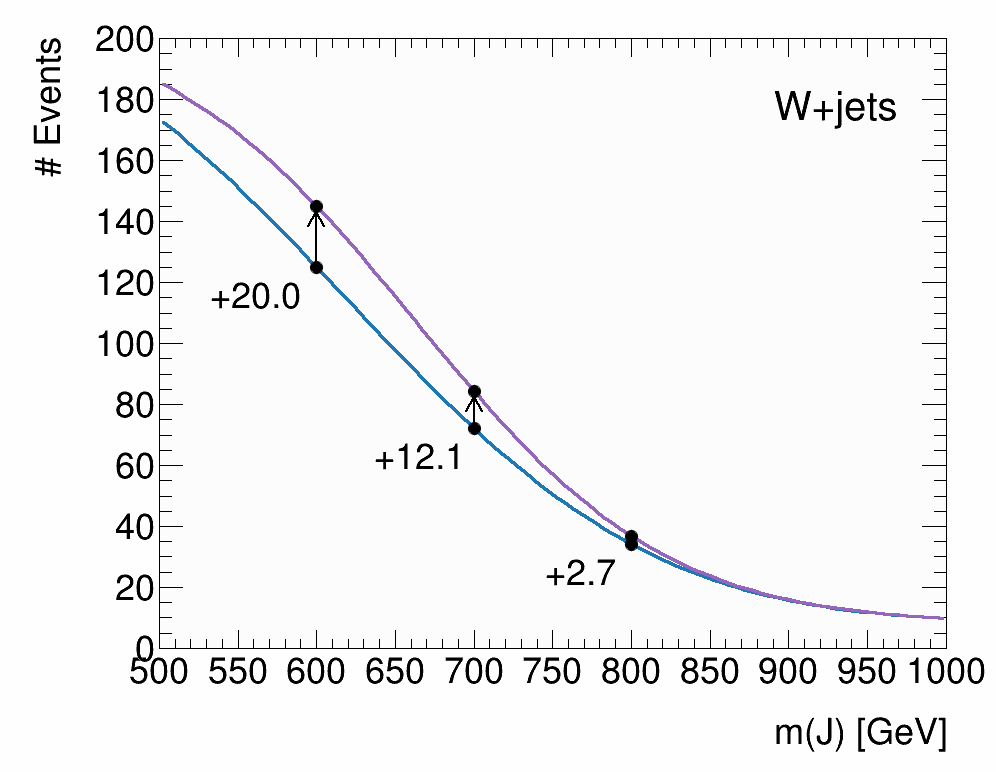

In [125]:
### Shift amounts at other points ###
f_new = funcs[-1]
points = [600, 700, 800]
markers = []
for p in points:
    m1 = ROOT.TMarker(p, f_orig(p), ROOT.kFullCircle)
    m1.SetMarkerSize(1.5)
    m2 = ROOT.TMarker(p, f_new(p), ROOT.kFullCircle)
    m2.SetMarkerSize(1.5)

    diff = f_new(p) - f_orig(p)
    if diff > 5:
        a = ROOT.TArrow(p, f_orig(p), p, f_new(p) - 2, 0.02, '>')
        a.SetLineWidth(2)

    t = ROOT.TLatex(p - 10, f_orig(p) - 5, f'+{diff:.1f}')
    t.SetTextAlign(ROOT.kHAlignRight + ROOT.kVAlignTop)
    markers.extend([m1, m2, a, t])

def add_ons():
    f_orig.Draw('SAME L')
    f_new.Draw('SAME L')
    for m in markers:
        m.Draw()

_ = pull_plot('gpr_hep_shift_vals.pdf', add_ons)